In [ ]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")
import seaborn as sns;sns.set()

In [ ]:
types = ['random','first','full','syndisc']
data = {'systemID':[],'parX':[],'upper':[],'totmi':[],'indivmi':[],'runtime':[],'exp_sort':[]}

folder = '../../results/initialsym/'
os.chdir(folder)
allfiles = glob.glob("*.pkl")
files = [file for file in allfiles if 'symcomparison' not in file and ]
# files=allfiles
ds=[]
if len(files) != 0:
    print(files)
    ds=pd.concat([pd.read_pickle(f) for f in files])
os.chdir('../../code/plot_notebooks')
# ds
# ds['states']=ds['parX'].apply(lambda x: int(np.sqrt(len(x)+1)))
# ds['indivmi/totmi'] = ds['indivmi']/ds['totmi']
# ds['wmsnorm'] = (ds['totmi']-ds['indivmi'])/ds['upper']
f=sns.jointplot(data=ds,y='syn_info',x='tot_runtime',hue='exp_sort',palette='tab10')
f.fig.suptitle("states="+str(5),y=1.0)


In [74]:
states=5
lenX=2
subjects=np.arange(lenX)
syns = ds[ds['states']==states]

if states == 5:
    print("LOAD LOWER ORDER AND FULL ONLY")
    with open('../../results/sudokus/permutation_sudokus_states'+str(states)+'.npy', 'rb') as f:
        fullsyms = np.load(f,allow_pickle=True)
        syms = list(fullsyms)
    with open('../../results/sudokus/lowerorder_sudokus_states'+str(states)+'.pkl', 'rb') as f:
        lowerorders=pickle.load(f)
        syms = syms+list(lowerorders)
    syms=np.array(syms)
else:
    with open('../../results/sudokus/constructedSRVstates'+str(states)+'.npy', 'rb') as f:
        syms = np.load(f,allow_pickle=True)
        
l,cs=classify_syms(syms,states)
cs.keys()

LOAD LOWER ORDER AND FULL ONLY


dict_keys(['full sym', 'noisy sym'])

In [75]:
def costfunc(srvparams,jXS,lenJXS,parX,subjects,upper):
    params2matrix_incremental(jXS,parX+list(srvparams))
    totmi = jXS.mutual_information(subjects,[lenJXS-1])
    indivmis = sum([jXS.mutual_information([i],[lenJXS-1]) for i in subjects])
    cost=abs((upper-(totmi-indivmis))/upper)
    if totmi != 0:
        return cost+((indivmis/totmi))
    else:
        return cost+(indivmis)

minimize_options = {'ftol': 1e-6}
def syminfo(states,lenX,jX,parX,upper,syms,initialtype='first'):
    subjects = list(range(lenX))
    jXS = append_random_srv(jX,parX,1)
    lenJXS = len(jXS)
    bestsymid=-1
    # get initial guess of best sym
    if initialtype!='random':
        if initialtype=='first':
            syms=[syms[0]]
        pXSym,bestsymid = addbestsym(lenX,jX,upper,syms)
        jXS.joint_probabilities.joint_probabilities = pXSym
    return bestsymid,jXS

pars = syns['parX']
types = ['symbestofall','symbest']
for i,p in enumerate(pars):
    print(i,time.strftime("%H:%M:%S", time.localtime()))
    jX = JointProbabilityMatrix(lenX,states)
    params2matrix_incremental(jX,p)
    pX = jX.joint_probabilities.joint_probabilities
    upper = synergistic_entropy_upper_bound(jX)
    for t in types:
        if t !='syndisc':
            if t =='symbestofall':
                cursyms = syms[cs['full sym']+cs['noisy sym']]
            elif t=='symbest':
                cursyms=syms[cs['full sym']]
            before = time.time()
            best, jXS = syminfo(states,lenX,jX,p,upper,\
                   cursyms,initialtype=t)
            data['runtime'].append(time.time()-before)
            data['indivmi'].append(sum([jXS.mutual_information([s],[lenX]) for s in subjects]))
            data['totmi'].append(jXS.mutual_information(subjects,[lenX]))
        else:
            ditjX = dit.Distribution.from_ndarray(pX)
            before = time.time()
            syn, probs = self_disclosure_channel(ditjX)
            data['runtime'].append(time.time()-before)
            data['indivmi'].append(0)
            data['totmi'].append(syn)
        data['exp_sort'].append(t)
        data['systemID'].append(i)
        data['upper'].append(upper)
        data['parX'].append(p)

for k in data.keys():
    print(k,len(data[k]))
initialdata = pd.DataFrame(data=data)
# initialdata.to_pickle("../../results/test/initialsymbestofallstates"+str(states)+".pkl") 
initialdata

0 01:24:02


C:\Users\enrik\Desktop\Mabomba\Studie\MasterCS\Thesis\code\jointpdfpython3\JointProbabilityMatrix.py:527: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item == 'all':


1 01:25:14
2 01:26:28
3 01:27:41
4 01:28:51
5 01:30:17
6 01:31:53
7 01:33:32
8 01:35:11
9 01:36:48
10 01:38:29
11 01:39:58
12 01:41:25
13 01:42:53
14 01:44:20
15 01:45:48
16 01:47:17
17 01:48:46
18 01:50:16
19 01:51:43
20 01:53:14
21 01:54:43
22 01:56:13
23 01:57:39
24 01:59:09
25 02:00:36
26 02:02:02
27 02:03:30
28 02:05:00
29 02:06:25
30 02:07:53
31 02:09:21
32 02:10:48
33 02:12:13
34 02:13:39
35 02:15:04
36 02:16:29
37 02:17:54
38 02:19:19
39 02:20:45
40 02:22:12
41 02:23:37
42 02:25:02
43 02:26:30
44 02:27:56
45 02:29:21
46 02:30:46
47 02:32:11
48 02:33:38
49 02:35:05
50 02:36:34
51 02:38:01
52 02:39:29
53 02:40:58
54 02:42:23
55 02:43:48
56 02:45:13
57 02:46:43
58 02:48:09
59 02:49:34
60 02:50:58
61 02:52:23
62 02:53:48
63 02:55:12
64 02:56:44
65 02:58:10
66 02:59:36
67 03:01:02
68 03:02:27
69 03:03:52
70 03:05:18
71 03:06:45
72 03:08:11
73 03:09:34
74 03:10:59
75 03:12:24
76 03:13:50
77 03:15:14
78 03:16:39
79 03:18:06
80 03:19:30
81 03:20:54
82 03:22:19
83 03:23:44
84 03:25:11
8

,systemID,parX,upper,totmi,indivmi,runtime,exp_sort
0,0,"[0.2018459130268977, 0.47212459284273234, 0.73...",1.615855,0.134448,0.006948,0.928050,symbestofall
1,0,"[0.2018459130268977, 0.47212459284273234, 0.73...",1.615855,1.813850,0.345343,0.293613,symbest
2,1,"[0.326560167750287, 0.3774228632005786, 0.5650...",1.544416,0.113552,0.013699,1.064206,symbestofall
3,1,"[0.326560167750287, 0.3774228632005786, 0.5650...",1.544416,1.806087,0.408965,0.248468,symbest
4,2,"[0.23326243829484505, 0.306301528360399, 0.555...",1.627746,0.174696,0.000981,1.067791,symbestofall
...,...,...,...,...,...,...,...
695,97,"[0.1100042346915821, 0.33741219958216967, 0.22...",1.561500,1.787364,0.385305,11.287873,symbest
696,98,"[0.17106878875699935, 0.21265798551855802, 0.5...",1.824623,0.059869,0.000659,74.452854,symbestofall
697,98,"[0.17106878875699935, 0.21265798551855802, 0.5...",1.824623,2.016966,0.342626,10.727869,symbest
698,99,"[0.3919173821275445, 0.15669993184560238, 0.48...",1.721716,0.037609,0.000571,74.087608,symbestofall


In [76]:
initialdata.to_pickle("../../results/test/initialonlysymstates"+str(states)+".pkl") 

## plot initial syms

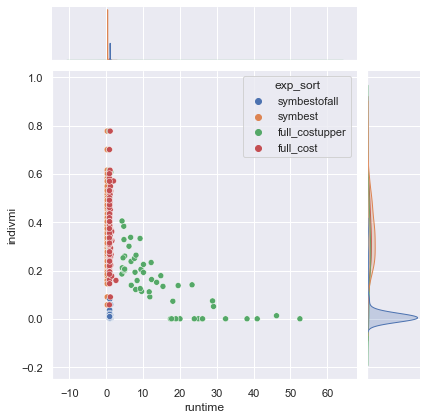

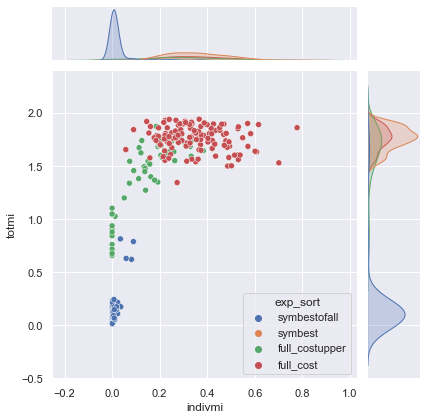

In [73]:
# new = pd.read_pickle("../../results/test/initialsymbestofallstates4.pkl")
# new = new.drop(new.index[[0]])
# old = pd.read_pickle("../../results/initialsym/initialsymcomparison4.pkl")
# old = old.drop(old.index[[0]])
# plot = pd.concat([old,new])
# plot = plot[(plot['exp_sort']=='random')|(plot['exp_sort']=='bestofall')]
plot=pd.concat([initialdata,syns])
sns.jointplot(data=plot,x='runtime',y='indivmi',hue='exp_sort')
sns.jointplot(data=plot,x='indivmi',y='totmi',hue='exp_sort')
# plot[(plot['upper']>1.367150)&(plot['upper']<1.387150)&(plot['systemID']==0)].index

# fig = plt.gcf()
# fig.set_size_inches(9,8)
# fig.suptitle('Bigger 1 row x 2 columns axes with no data')
# gs = gridspec.GridSpec(2,1)
# g = sns.jointplot(data=plot,x='runtime',y='indivmi',hue='exp_sort')
# m = SeabornFig2Grid(g, fig, axes[0]) 
# g = sns.jointplot(data=plot,x='indivmi',y='totmi',hue='exp_sort')
# m = SeabornFig2Grid(g, fig, axes[1]) 
# plt.show()

In [3]:
lenX = 2
states = 2
subjects = list(range(lenX))
# load constructed srvs
with open('../../results/sudokus/constructedSRVstates'+str(states)+'.npy', 'rb') as f:
    syms = np.load(f,allow_pickle=True)
l, cs = classify_syms(syms,states)
    
# load data
dist_type = 'random'
folder = '../../results/test/'
name = dist_type +'states'+str(states)
allfiles = glob.glob(folder+"*.pkl")
files = [file for file in allfiles if name in file]
files = [files[-1]]
if len(files) != 0:
    print(files)
    d = pd.concat([pd.read_pickle(f) for f in files])

print(len(syms),len(d),d.keys())
d = load_frame(states,dist_type,folder,d)
d['symwms']=d['I(X;initialsym)']-d['I(Xi;initialsym)']
d['normsymwms']=d['symwms']/d['syn_upper']


['../../results/test\\randomstates2both.pkl']
21 1000 Index(['systemID', 'parX', 'pX', 'syn_upper', 'H(Xi)', 'I(X1;X2)', 'statesS',
       'lenS', 'tot_runtime', 'syn_info', 'srv_data', 'pXS', 'pXinitialsym',
       'H(initialsym|bestsym)', 'I(X;initialsym)', 'I(Xi;initialsym)',
       'H(initialsym)', 'exp_sort', 'steps', 'lenX', 'states'],
      dtype='object')


In [14]:
def bestclass(row,syms,classes):
    print(row['systemID'])
    bestid = getbestsym(row.lenX,row['syn_upper'],row['pX'],row['pXS'],syms)[1]
    return [k for k, v in classes.items() if bestid in v][0]

histdata = d.apply(lambda row: bestclass(row,syms,cs),axis=1)
histdata.to_pickle("./hist_bestsymclassstates"+str(states)+".pkl") 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<AxesSubplot:>

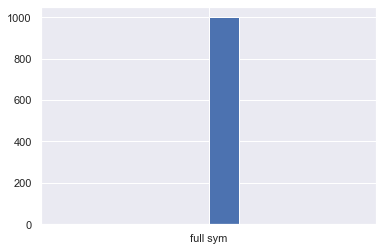

In [15]:
histdata = pd.read_pickle("hist_bestsymclassstates"+str(states)+".pkl")
histdata.hist()

## Compare scores optimized sym vs syndisc vs initial gues...

In [10]:
# plot=d
# valuevars = ['syn_info','symwms']
# plotmelt = pd.melt(plot, id_vars=['systemID','syn_upper','I(X1;X2)',\
#                                   'I(Xi;S)','I(Xi;initialsym)'], value_vars=valuevars,
#            var_name='exp_sort', value_name='WMS')

# # valuevars = ['WMS(X;S)','normsymwms']
# # plotmelt2 = pd.melt(plot, id_vars=['systemID','syn_upper','I(X1;X2)',\
# #                                   'I(Xi;S)','I(Xi;initialsym)'], value_vars=valuevars,
# #            var_name='exp_sort', value_name='normWMS')

# valuevars = ['I(Xi;S)','I(Xi;initialsym)']
# plotmelt3 = pd.melt(plot, id_vars=['systemID','syn_upper','I(X1;X2)'], value_vars=valuevars,
#            var_name='exp_sort', value_name='indivmi')

# plot = plotmelt3
# # plot['normWMS']=plotmelt2['normWMS']
# plot['WMS'] = plotmelt['WMS']

# tol = 0.01
# plot=plot[plot['indivmi']<tol]
# plot

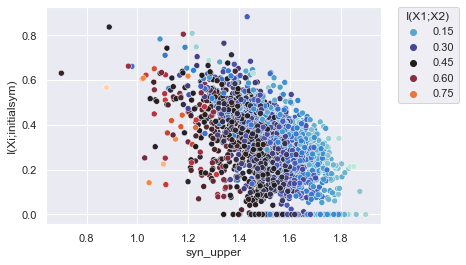

In [11]:
hue='I(X1;X2)'
sns.scatterplot(data=d,x='syn_upper',y='I(Xi;initialsym)',hue=hue,palette='icefire')
# sns.lineplot(data=d,x='syn_upper',y='syn_upper',color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.01,title=hue)
